# ARIMA fitting

This file contains ARIMA fitting methods. It considers identifying the order of differencing, and model selection using package pmdarima, AIC, and Ljung-Box test.

The practical foundation of this code is based on: https://github.com/Auquan/Tutorials/blob/master/Time%20Series%20Analysis%20-%202.ipynb, https://github.com/Auquan/Tutorials/blob/master/Time%20Series%20Analysis%20-%203.ipynb.

In [56]:
import os
import sys

import pandas as pd
import numpy as np
import math

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm

import matplotlib.pyplot as plt
import matplotlib as mpl

In [75]:
data = pd.read_csv('EURUSD_2019_01_03_without-ID.csv', header=0, index_col=None, parse_dates=['Datetime'])
#data = pd.read_csv('BTCUSDT-trades-2022-01-03_parsedDate.csv', header=0, index_col='myID', parse_dates=['Datetime'])

data = data['Middle'] # for Tick data
#data = data['price'] # for Binance data

print(data.shape)

# log returns
# np.log(data/data.shift(1)) == np.log(data) - np.log(data.shift(1)) ≈ (data - data.shift(1)) / data.shift(1)
lrets = np.log(data/data.shift(1)).fillna(0) # np.log - is the natural logarithm
                                             # x.t/x.t-1

    
print(lrets)
print("Data preparing done.")

(313,)
0      0.000000
1     -0.013077
2      0.006849
3      0.000496
4      0.001267
         ...   
308    0.006590
309    0.000599
310    0.001792
311    0.000879
312    0.000682
Name: Close, Length: 313, dtype: float64
Data preparing done.


In [58]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh', model = ""):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots - %s' % (model))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, zero=0, auto_ylims=True)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, method='ywm', zero=0, auto_ylims=True)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
        
        #plt.savefig('acf.pdf', format='pdf', bbox_inches="tight")
    return

In [76]:
def corr_plot(y, lags=None, figsize=(9, 2.5), style='bmh', model = ""):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    fig = plt.figure(figsize=figsize)    
    layout = (1, 2)
    
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))

    acf_ax.grid(True)
    pacf_ax.grid(True)    
   
    plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, zero=False, auto_ylims=True)
    plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, method='ywm', zero=False, auto_ylims=True)    
    
    plt.tight_layout()    
    #plt.savefig('acf+pacf.pdf', format='pdf', bbox_inches="tight")
    plt.show()

## Plot raw lrets

(-8.281964816527198, 4.494524609282294e-13, 9, 303, {'1%': -3.4521175397304784, '5%': -2.8711265007266666, '10%': -2.571877823851692}, -2576.092440806937)


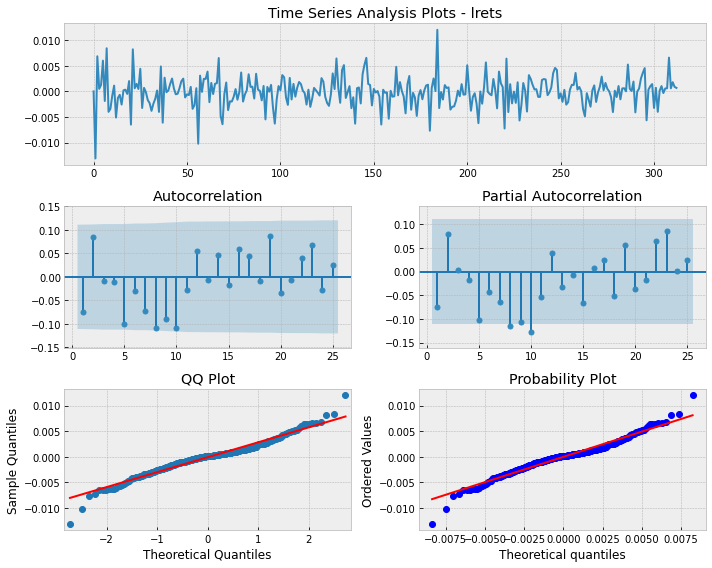

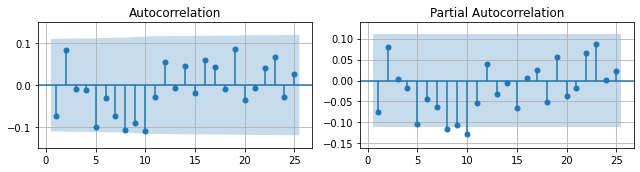

In [77]:
tsplot(lrets, lags=25, model=('lrets'))
print(smt.adfuller(x=lrets, maxlag=25))
corr_plot(lrets, lags=25)

## ARIMA

For quick fitting of ARIMA model.

C:\Users\Dom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


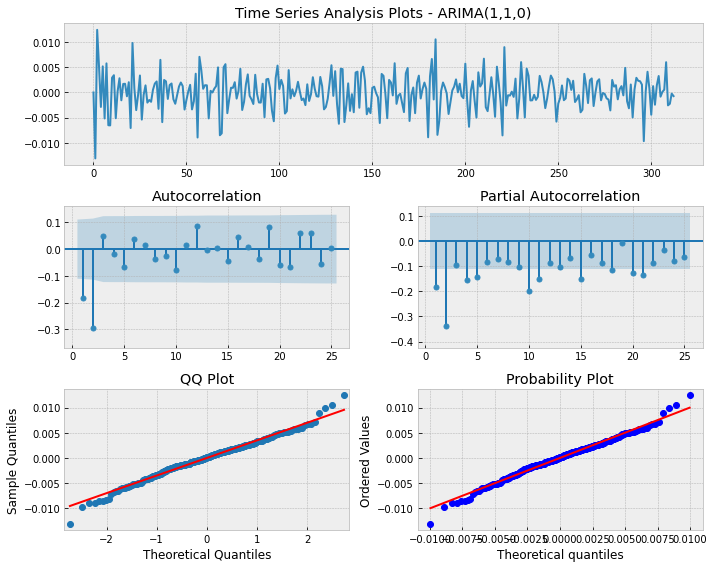

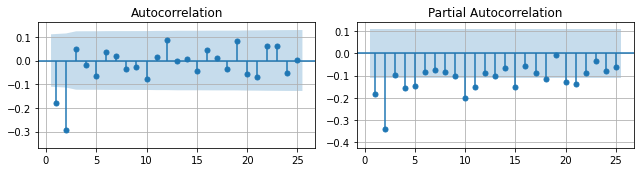

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  313
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1323.707
Date:                Fri, 14 Apr 2023   AIC                          -2643.413
Time:                        17:44:58   BIC                          -2635.927
Sample:                             0   HQIC                         -2640.421
                                - 313                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5739      0.035    -16.577      0.000      -0.642      -0.506
sigma2      1.207e-05   9.04e-07     13.352      0.000    1.03e-05    1.38e-05
Ljung-Box (L1) (Q):                   9.81   Jarque-

In [81]:
order = (1,1,0)
mdl = ARIMA(endog=lrets, order=order).fit()

tsplot(mdl.resid, lags=25, model=('ARIMA(%s,%s,%s)' % (order[0], order[1], order[2])))
corr_plot(mdl.resid, lags=25)

print(mdl.summary())
ljung = sms.diagnostic.acorr_ljungbox(mdl.resid, lags=[25], boxpierce=False)
print(ljung)

print('Mean: ', np.mean(mdl.resid))

## Order determination AIC

Determination of ARIMA order using AIC criterion. Number of differencing must be determined before.

C:\Users\Dom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Dom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Dom\A

{(0, 0, 0): -2762.93130809, (2, 0, 0): -2762.7658069949384, (0, 0, 2): -2762.7112139497503}
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  313
Model:                          ARIMA   Log Likelihood                1383.466
Date:                Fri, 14 Apr 2023   AIC                          -2762.931
Time:                        17:45:34   BIC                          -2755.439
Sample:                             0   HQIC                         -2759.937
                                - 313                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.328e-05      0.000     -0.443      0.658      -0.000       0.000
sigma2      8.507e-06   4.62e-07     18

C:\Users\Dom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  313
Model:                 ARIMA(0, 0, 2)   Log Likelihood                1385.356
Date:                Fri, 14 Apr 2023   AIC                          -2762.711
Time:                        17:45:36   BIC                          -2747.726
Sample:                             0   HQIC                         -2756.723
                                - 313                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.307e-05      0.000     -0.418      0.676      -0.000       0.000
ma.L1         -0.0456      0.051     -0.886      0.376      -0.146       0.055
ma.L2          0.0874      0.064      1.365      0.1

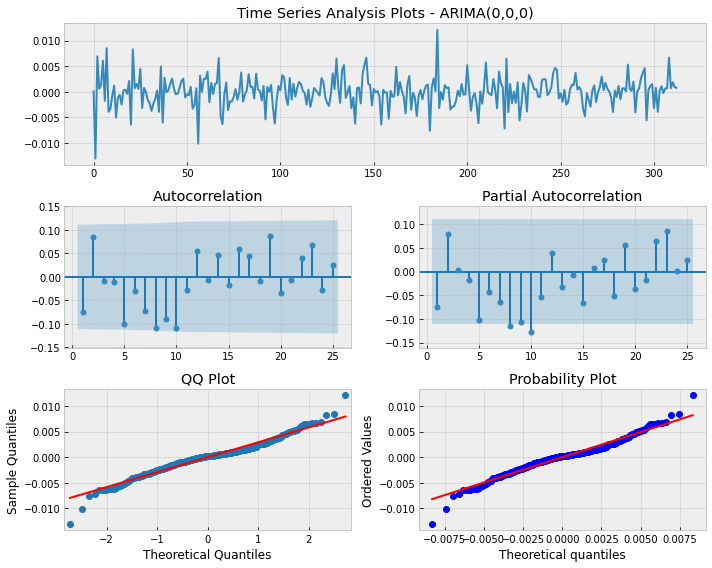

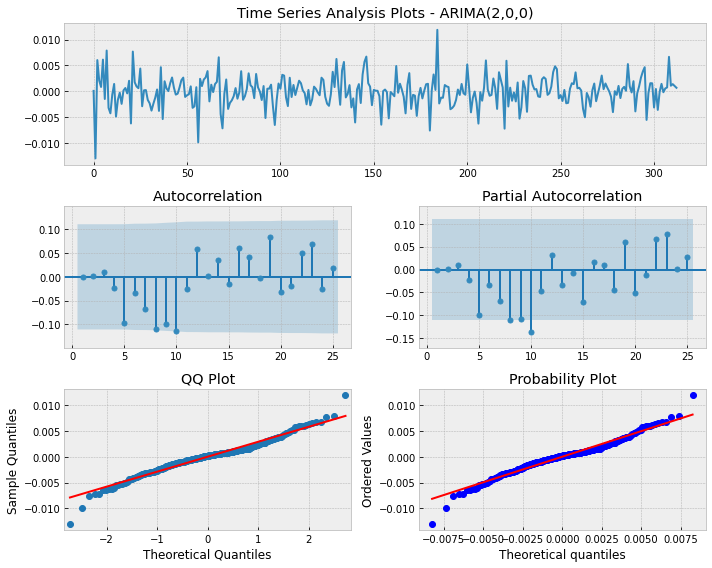

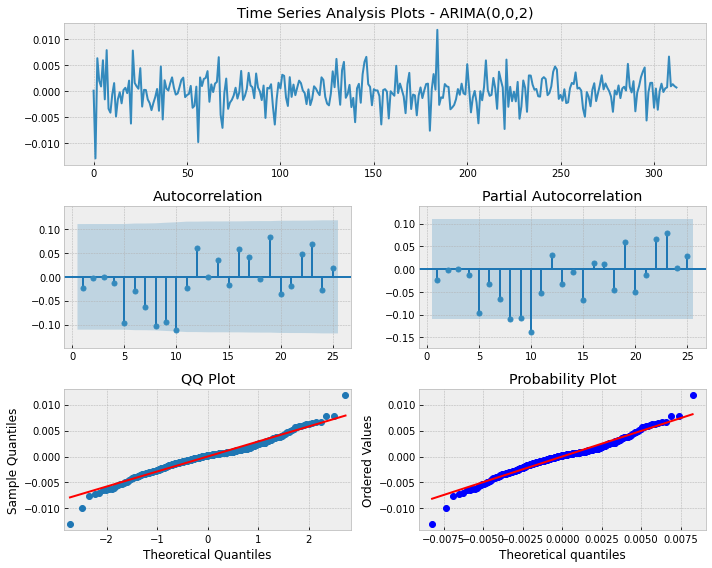

In [82]:
diff = 0
ar_range = range(0,6)
ma_range = range(0,4)

aics = dict() # key:order, item:AIC

for ar in ar_range:
    for ma in ma_range:
        mdl = ARIMA(endog=lrets, order=(ar,diff,ma)).fit()        
        aics[(ar, diff, ma)] = mdl.aic
            
aics_sorted = dict(sorted(aics.items(), key=lambda item: item[1])) # sorts dict asc according to items (aics)
best_aics = dict(list(aics_sorted.items())[0:3]) # choose first three smallest aics + orders

print(best_aics)

# iterates through keys in dict
for order in best_aics: 
    mdl = ARIMA(endog=lrets, order=order).fit()        
    tsplot(mdl.resid, lags=25, model=('ARIMA(%s,%s,%s)' % (order[0], order[1], order[2])))
    print(mdl.summary())
    
    print(sms.diagnostic.acorr_ljungbox(mdl.resid, lags=[25], boxpierce=False))
    print(scs.jarque_bera(mdl.resid))

## PMD ARIMA

Determination of ARIMA order using pmd arima package. It determines order including differencing.

In [55]:
model = pm.auto_arima(y=lrets, 
                     start_p=2, 
                     d=None, 
                     start_q=2, 
                     max_p=4,
                     max_d=2, 
                     max_q=4, 
                     max_order=10,
                     stepwise=True, 
                     n_jobs=1,    
                     seasonal=False, 
                     stationary=False,
                     # most likely no need to change, just to know that there are such a possibilities to change
                     information_criterion='aic', 
                     alpha=0.05, test='kpss', 
                     seasonal_test='ocsb',                                     
                     method='lbfgs', 
                     random=False,  
                     n_fits=10, 
                     return_valid_fits=False,                     
                     with_intercept='auto')

print(model.summary())

# p = model.get_params().get('order')
# print(p)
# print(type(p))

C:\Users\Dom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\Dom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\Dom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\Dom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmo

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               885624
Model:               SARIMAX(4, 0, 0)   Log Likelihood             8053452.875
Date:                Sun, 09 Apr 2023   AIC                      -16106895.750
Time:                        16:43:27   BIC                      -16106837.280
Sample:                             0   HQIC                     -16106879.580
                             - 885624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0889   3.19e-22  -2.79e+20      0.000      -0.089      -0.089
ar.L2         -0.0177   3.97e-22  -4.47e+19      0.000      -0.018      -0.018
ar.L3          0.0025   1.28e-22   1.96e+19      0.0